# Programming Exercise 8: Anomaly Detection and Recommender Systems

# 1 Anomaly detection

In [2]:
import numpy as np
from scipy.io import loadmat

X = loadmat('data/ex8data1.mat')['X']
X.shape

(307, 2)

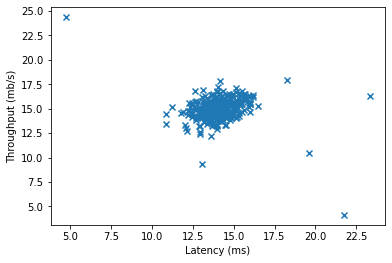

In [3]:
import matplotlib.pyplot as plt

def plot_X(X):
    plt.scatter(*zip(*X), marker='x')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    plt.show()
    
plot_X(X)

# 1.1 Gaussian distribution

# 1.2 Estimating parameters for a Gaussian

In [4]:
def estimate_gaussian(X):
    return X.mean(axis=0), X.var(axis=0)

mu, sigma2 = estimate_gaussian(X)
mu, sigma2

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

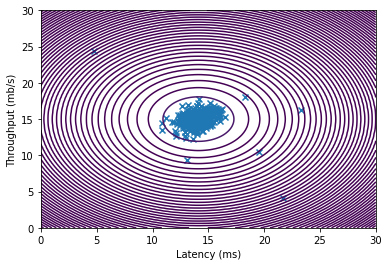

In [5]:
def get_p(X, mu, sigma2):
    return (1 / ((2 * np.pi * sigma2) ** 0.5) * np.exp(-(X - mu) ** 2 / 2 / sigma2)).prod(axis=1)

xl, xt = np.meshgrid(np.linspace(0, 30, 200), np.linspace(0, 30, 200))
pp = get_p(np.array(list(zip(xl.flatten(), xt.flatten()))), mu, sigma2).reshape((len(xl), len(xt)))

# 因为存在数量级上的差异，这里选择了 logspace 来快速画 level，但在精确找 epsilon 时，还是要用 linspace
levels = np.logspace(np.emath.logn(0.5, pp.min()), np.emath.logn(0.5, pp.max()), num=50, base=0.5)
plt.contour(xl, xt, pp, levels=levels)
plot_X(X)

# 1.3 Selecting the threshold, $\epsilon$

In [6]:
Xval = loadmat('data/ex8data1.mat')['Xval']
yval = loadmat('data/ex8data1.mat')['yval'][:, 0]
pval = get_p(Xval, mu, sigma2)

In [7]:
def select_threshold(pval, yval):
    # 用 logspace 效果特别差，还是要用 linspace 更精细一些
    # epsilon_options = np.logspace(np.emath.logn(0.5, pval.min()), np.emath.logn(0.5, pval.max()), num=500, base=0.5)
    epsilon_options = np.linspace(np.min(pval), np.max(pval), num=1001)
    f1_score_options = []
    for epsilon in epsilon_options:
        ypred = pval < epsilon
        if sum(ypred == 1) == 0:
            f1_score_options.append(0)
            continue
        prec = sum((ypred == yval) & (ypred == 1)) / sum(ypred == 1)
        rec = sum((ypred == yval) & (ypred == 1)) / sum(yval == 1)
        f1_score = 2 * prec * rec / (prec + rec)
        f1_score_options.append(f1_score)
    return epsilon_options[np.argmax(f1_score_options)], max(f1_score_options)

epsilon, f1_score = select_threshold(pval, yval)
epsilon, f1_score

(8.990852779269492e-05, 0.8750000000000001)

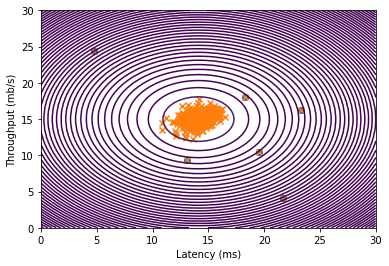

In [8]:
xl, xt = np.meshgrid(np.linspace(0, 30, 200), np.linspace(0, 30, 200))
pp = get_p(np.array(list(zip(xl.flatten(), xt.flatten()))), mu, sigma2).reshape((len(xl), len(xt)))
levels = np.logspace(np.emath.logn(0.5, pp.min()), np.emath.logn(0.5, pp.max()), num=50, base=0.5)
plt.contour(xl, xt, pp, levels=levels)

plt.scatter(*zip(*X[get_p(X, mu, sigma2) < epsilon]), marker='o')

plot_X(X)

# 1.4 High dimensional dataset

In [9]:
X = loadmat('data/ex8data2.mat')['X']
Xval = loadmat('data/ex8data2.mat')['Xval']
yval = loadmat('data/ex8data2.mat')['yval'][:, 0]

mu, sigma2 = estimate_gaussian(X)
pval = get_p(Xval, mu, sigma2)
epsilon, f1_score = select_threshold(pval, yval)
epsilon, sum(get_p(X, mu, sigma2) < epsilon)

(1.377228890761357e-18, 117)

# 2 Recommender Systems

# 2.1 Movie ratings dataset

In [10]:
Y = loadmat('data/ex8_movies.mat')['Y']
R = loadmat('data/ex8_movies.mat')['R']
X = loadmat('data/ex8_movieParams.mat')['X']
Theta = loadmat('data/ex8_movieParams.mat')['Theta']
num_users = loadmat('data/ex8_movieParams.mat')['num_users'][0, 0]
num_movies = loadmat('data/ex8_movieParams.mat')['num_movies'][0, 0]
num_features = loadmat('data/ex8_movieParams.mat')['num_features'][0, 0]

Y.shape, R.shape, X.shape, Theta.shape, num_users, num_movies, num_features

((1682, 943), (1682, 943), (1682, 10), (943, 10), 943, 1682, 10)

# 2.2 Collaborative filtering learning algorithm

In [11]:
def cf_cost_function(X, Theta, R, Y):
    return sum((X @ Theta.T - Y).flatten()[R.flatten() == 1] ** 2) / 2

def cfw_cost_function(theta, R, Y, num_movies, num_users, num_features):
    spam = theta.reshape((round(len(theta) / num_features), num_features))
    X = spam[:num_movies, :]
    Theta = spam[num_movies:num_movies + num_users, :]
    return cf_cost_function(X, Theta, R, Y)

def cf_cost_function_reg(X, Theta, R, Y, lam):
    return cf_cost_function(X, Theta, R, Y) + lam / 2 * ((X ** 2).sum() + (Theta ** 2).sum())

def cfw_cost_function_reg(theta, R, Y, num_movies, num_users, num_features, lam):
    spam = theta.reshape((round(len(theta) / num_features), num_features))
    X = spam[:num_movies, :]
    Theta = spam[num_movies:num_movies + num_users, :]
    return cf_cost_function_reg(X, Theta, R, Y, lam)

cf_cost_function(X[:5, :3], Theta[:4, :3], R[:5, :4], Y[:5, :4])

22.22460372568567

In [12]:
def cf_gradient(X, Theta, R, Y):
    spam = X @ Theta.T
    spam[R == 0] = 0
    X_grad = (spam - Y) @ Theta
    Theta_grad = (spam - Y).T @ X
    return np.concatenate((X_grad, Theta_grad), axis=0).flatten()

def cfw_gradient(theta, R, Y, num_movies, num_users, num_features):
    spam = theta.reshape((round(len(theta) / num_features), num_features))
    X = spam[:num_movies, :]
    Theta = spam[num_movies:num_movies + num_users, :]
    return cf_gradient(X, Theta, R, Y)

def cf_gradient_reg(X, Theta, R, Y, lam):
    spam = X @ Theta.T
    spam[R == 0] = 0
    X_grad = (spam - Y) @ Theta + lam * X
    Theta_grad = (spam - Y).T @ X + lam * Theta
    return np.concatenate((X_grad, Theta_grad), axis=0).flatten()

def cfw_gradient_reg(theta, R, Y, num_movies, num_users, num_features, lam):
    spam = theta.reshape((round(len(theta) / num_features), num_features))
    X = spam[:num_movies, :]
    Theta = spam[num_movies:num_movies + num_users, :]
    return cf_gradient_reg(X, Theta, R, Y, lam)

cf_gradient(X, Theta, R, Y)[:10]

array([-6.26184144,  2.45936046, -6.87560329, -1.43633721, -2.09499698,
       -5.43040045,  0.26446931, -4.81611896,  3.84341521, -1.88786696])

In [13]:
# Graident checking

epsilon = 10e-4
cfw_gradient_numeric = []
theta = np.concatenate((X, Theta), axis=0).flatten()

for i in range(len(theta))[:10]:
    err = np.zeros_like(theta)
    err[i] = epsilon
    theta_pos = theta + err
    theta_neg = theta - err
    cfw_gradient_numeric.append((cfw_cost_function(theta_pos, R, Y, num_movies, num_users, num_features) - cfw_cost_function(theta_neg, R, Y, num_movies, num_users, num_features)) / 2 / epsilon)

cfw_gradient_numeric = np.array(cfw_gradient_numeric)
cfw_gradient_numeric[:10] # 几乎一模一样，说明计算正确

array([-6.26184144,  2.45936045, -6.87560329, -1.43633721, -2.09499698,
       -5.43040045,  0.2644693 , -4.81611896,  3.84341522, -1.88786696])

# 2.3 Learning movie recommendations

In [14]:
with open('data/movie_idx.txt') as f:
    movies = [spam[spam.index(' '):].strip() for spam in f.readlines()]

len(movies)

1682

         Current function value: 71896.075501
         Iterations: 1000
         Function evaluations: 1504
         Gradient evaluations: 1504


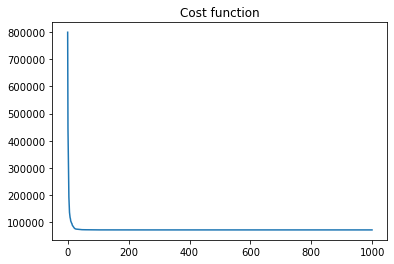

In [23]:
from scipy.optimize import fmin_cg

def learning(X, Theta, R, Y, num_movies, num_users, num_features, lam):
    theta = np.concatenate((X, Theta), axis=0).flatten()
    costs = []
    def cb(theta):
        costs.append(cfw_cost_function_reg(theta, R, Y, num_movies, num_users, num_features, lam))
    # 迭代 7000 次迭代会花费 10min，所以建议限制 maxiter=1000
    result = fmin_cg(cfw_cost_function_reg, theta, cfw_gradient_reg, (R, Y, num_movies, num_users, num_features, lam), maxiter=1000, callback=cb)
    plt.plot(costs)
    plt.title('Cost function')
    plt.show()
    return result

# Input my ratings
my_ratings = np.zeros(num_movies)
my_ratings[0] = 4
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

Ynew = np.concatenate((Y, my_ratings[:, None]), axis=1)
Rnew = np.concatenate((R, (my_ratings != 0)[:, None]), axis=1)

# Initialization
X = np.random.randn(Ynew.shape[0], num_features)
Theta = np.random.randn(Ynew.shape[1], num_features)

# Normalization：标准化后会遇到 precision loss 问题，学不出来
# Ymean = Ynew.sum(axis=1) / Rnew.sum(axis=1)
# Ynorm = Ynew - Ymean[:, None]

lam = 10

theta_opt = learning(X, Theta, Rnew, Ynew, num_movies, Ynew.shape[1], num_features, lam)

In [33]:
import pandas as pd

spam = theta_opt.reshape((round(len(theta_opt) / num_features), num_features))
X_opt = spam[:num_movies, :]
Theta_opt = spam[num_movies:num_movies + num_users, :]
Y_pred = X_opt @ Theta_opt.T

my_predictions = pd.DataFrame((movies, my_ratings, Y_pred[:, -1]), index=('movie', 'rate', 'predict')).T
my_predictions.to_csv('my_predictions.csv')
my_predictions

,movie,rate,predict
0,Toy Story (1995),4,4.15888
1,GoldenEye (1995),0,3.17922
2,Four Rooms (1995),0,2.99457
3,Get Shorty (1995),0,3.28216
4,Copycat (1995),0,3.07108
...,...,...,...
1677,Mat' i syn (1997),0,0.283204
1678,B. Monkey (1998),0,0.849612
1679,Sliding Doors (1998),0,0.566408
1680,You So Crazy (1994),0,0.714747


In [32]:
# Top 10 predictions for me
my_predictions[my_predictions['rate'] == 0].sort_values('predict', ascending=False).head(10)

,movie,rate,predict
287,Scream (1996),0,5.39806
10,Seven (Se7en) (1995),0,5.13966
271,Good Will Hunting (1997),0,5.00321
312,Titanic (1997),0,4.89394
55,Pulp Fiction (1994),0,4.89187
332,"Game, The (1997)",0,4.77123
126,"Godfather, The (1972)",0,4.7593
514,"Boot, Das (1981)",0,4.74044
116,"Rock, The (1996)",0,4.73533
762,Happy Gilmore (1996),0,4.73426
